---
title: "Varying Coefficient Boosting for geospatial and temporal data"
author: "Sarem"
date: "2023-05-10"
categories: [Decision Trees, Gradient Boosting]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "(More degrees of) Freedom for linear models!"
---

## Introduction

[Last time](https://sarem-seitz.com/posts/with-pytorch-i-can-gradient-boost-anything/#:~:text=Varying%20Coefficient%20Boosting), amongst other ideas, we looked at how to implement Varying Coefficient Boosting in PyTorch. These types of models are quite useful, as they are considerably flexible and (locally) interpretable at the same time. 

By using Boosted Decision Trees, we even gain some interpretability for the coefficient functions themselves. The well-known predictive performance of Gradient Boosting also seems to apply for such models. Personally, I believe that these two aspects makes Gradient Boosting with Decision Trees the preferred base-method for the Varying Coefficient approach.

Today, we will look at how to apply this approach to geospatial data and data with a prevalent temporal component. Our main goal is to let the coefficients vary over space and/or time. This should improve interpretability even further - the model coefficients will only change per region or per time period. Especially for geospatial data, we can then make some neat geo-plots to visualize the results.

## Adapting the Varying Coefficient model from before
If you take a close look at the previous implementation of Varying Coefficient Boosting, you will notice one important aspect: Our model presumed that the coefficient function features and the regression features are equivalent. I.e., in the model formula

$$\hat{y} = F^{(0)}(x) + F^{(1)}(x)\cdot x^{(1)} + \cdots F^{(M)}(x)\cdot x^{(M)},$$

we could not allow the $x$ in $F^{(m)}(x)$ to be different from the $x^{(m)}$ in $x^{(m)}$. Now, however, input vector $x$ is presumed to contain, for example, $x^\text{lat}$ and $x^\text{lon}$ or $x^\text{year}$ and $x^\text{month}$. We therefore only want those features to be used in the $F^{(m)}(x)$. For the actual regressors, we will use the remaining features, $x\setminus \{x^\text{lat}, x^\text{lon},...\}$.

Thus, we introduce `X_reg` and `X_coeff` in the `.fit` and `.predict` methods to differentiate both feature sets. Adjusting the existing model class is then fairly straightforward:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import json

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

from typing import List, Optional, Union


###Model

class VaryingCoefficientGradientBoosting:

    def __init__(self,
                 learning_rate: float = 0.025,
                 max_depth: int = 1,
                 n_estimators: int =100):

        self.learning_rate: float = learning_rate
        self.max_depth: int = max_depth
        self.n_estimators: int = n_estimators

        self.init_coeffs: Optional[float] = None
        self.coeff_trees: List[List[DecisionTreeRegressor]] = []
        
        self.is_trained: bool = False


    @property
    def n_coefficients(self) -> int:
        if self.is_trained:
            return self.init_coeffs.shape[1]
        else:
            return 0 


    def predict(self, X_reg: np.array, X_coeff: np.array) -> np.array:
        assert self.is_trained

        X_reg = np.concatenate([np.ones(shape = (len(X_reg), 1)), X_reg], 1)

        coeffs = self._predict_coeffs(X_coeff)
        predictions = np.sum(X_reg * coeffs, 1)

        return predictions


    def _predict_raw(self, X_coeff: np.array) -> np.array:
        assert self.is_trained
        return self._predict_coeffs(X_coeff)
    

    def fit(self, X_reg: np.array, X_coeff: np.array, y: np.array) -> None:
        X_reg = np.concatenate([np.ones(shape = (len(X_reg), 1)), X_reg], 1)
        self._fit_initial(X_reg, y)

        self.is_trained = True

        for _ in range(self.n_estimators):
            coeff_pred = self._predict_raw(X_coeff)

            gradients = self._get_gradients(X_reg, y, coeff_pred)

            new_trees = []

            for c in range(self.n_coefficients):
                coeff_tree = DecisionTreeRegressor(max_depth=self.max_depth)
                coeff_tree.fit(X_coeff, gradients[:,c])

                new_trees.append(coeff_tree)

            self.coeff_trees.append(new_trees)


    def _fit_initial(self, X_reg: np.array, y: np.array) -> None:
        assert not self.is_trained

        self.init_coeffs = np.zeros(shape = (1, X_reg.shape[1]))
        self.init_coeffs[0,0] = np.mean(y)


    def _get_gradients(self, X_reg: np.array, y: np.array, coeff_pred: np.array) -> np.array:
        X_torch = torch.tensor(X_reg).float()
        y_torch = torch.tensor(y).float()
        y_pred_torch = Variable(torch.tensor(coeff_pred).float(), requires_grad=True)

        sse = -0.5 * (y_torch-(X_torch * y_pred_torch).sum(1)).pow(2.0).sum() #negative sse to get negative gradient
        sse.backward() 
        grads = y_pred_torch.grad.numpy()

        grads[grads > np.quantile(grads, 0.95)] = np.quantile(grads, 0.95)
        grads[grads < np.quantile(grads, 0.05)] = np.quantile(grads, 0.05)

        return grads


    def _predict_coeffs(self, X_coeff: np.array) -> np.array:
        output = np.zeros(shape = (len(X_coeff), self.n_coefficients))

        output += self.init_coeffs

        for tree_list in self.coeff_trees:
            for c in range(self.n_coefficients):
                output[:,c] += self.learning_rate * tree_list[c].predict(X_coeff)

        return output

Not too difficult. Next, we can directly apply this updated model to the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

### Varying Coefficient Boosting for California Housing

To accomodate for our updated model, we obviously need to split our features into `X_reg` and `X_coeff`, too. Since we also want to keep using `train_test_split` from `sklearn`, which expects only one feature matrix, we apply the latter first. Also, for comparison, we will fit a regular Gradient Boosting model to the data. This requires another set of features, namely `X_train_scaled` and `X_test_scaled` where we use the full feature set for the standard Boosting model:

In [12]:
### Data

housing = fetch_california_housing()
X = housing.data

y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

X_train_reg = X_train[:, :-2]
X_train_coeff = X_train[:, -2:]
X_test_reg = X_test[:, :-2]
X_test_coeff = X_test[:, -2:]

X_reg_mean = np.mean(X_train_reg, 0)
X_reg_std = np.std(X_train_reg, 0)

X_train_reg = (X_train_reg - X_reg_mean) / X_reg_std
X_test_reg = (X_test_reg - X_reg_mean) / X_reg_std

X_full_mean = np.mean(X_train, 0)
X_full_std = np.std(X_train, 0)

X_train_scaled = (X_train - X_full_mean) / X_full_std
X_test_scaled = (X_test - X_full_mean) / X_full_std

y_mean = np.mean(y_train)
y_std = np.std(y_train)

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

### Models
np.random.seed(123)

model = VaryingCoefficientGradientBoosting(n_estimators=100, max_depth=2, learning_rate = 0.1)
model.fit(X_train_reg, X_train_coeff, y_train)

predictions_varcoeff = model.predict(X_test_reg, X_test_coeff)

rmse_varcoeff = np.sqrt(np.mean((predictions_varcoeff - y_test)**2))


gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=2, learning_rate = 0.1)
gb_model.fit(X_train_scaled, y_train)

predictions_gb = gb_model.predict(X_test_scaled)

rmse_gb = np.sqrt(np.mean((predictions_gb - y_test)**2))


For further comparison, we also fit a Varying Coefficient Neural Network. As with Varying Coefficient Boosting, the geographical features are used for the coefficient functions, while the remaining ones are used as regressors. The model is implemented in PyTorch, using the `nn` module. The model is fairly simple, with only one hidden layer:

In [13]:
class VaryingCoefficientNeuralNetwork(nn.Module):
    def __init__(self, input_dim, varying_input_dim, hidden_dim):
        super(VaryingCoefficientNeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.varying_input_dim = varying_input_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(varying_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim+1)

    def forward(self, x, x_varying):
        varying_coeffs = self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(x_varying)))))
        x_with_ones = torch.cat([torch.ones(x.shape[0], 1), x], 1)

        result = torch.sum(x_with_ones * varying_coeffs, 1) 
        return result

    def predict_coefficients(self, x_varying):
        varying_coeffs = self.fc2(nn.Softplus()(self.fc1(x_varying)))
        return varying_coeffs

np.random.seed(123)
torch.manual_seed(123)

model_net = VaryingCoefficientNeuralNetwork(input_dim=X_train_reg.shape[1]+1, varying_input_dim=X_train_coeff.shape[1], hidden_dim=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_net.parameters(), lr=0.001)

X_train_reg_tensor = torch.tensor(X_train_reg).float()
X_train_reg_tensor = torch.cat([torch.ones(X_train_reg_tensor.shape[0], 1), X_train_reg_tensor], 1)

X_test_reg_tensor = torch.tensor(X_test_reg).float()
X_test_reg_tensor = torch.cat([torch.ones(X_test_reg_tensor.shape[0], 1), X_test_reg_tensor], 1)

X_train_coeff_tensor = torch.tensor(X_train_coeff).float()
X_test_coeff_tensor = torch.tensor(X_test_coeff).float()

y_train_tensor = torch.tensor(y_train).float()

num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_net(X_train_reg_tensor, X_train_coeff_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

predictions = model_net(X_test_reg_tensor, X_test_coeff_tensor)

rmse_var_coeff_net = np.sqrt(np.mean((predictions.detach().numpy() - y_test)**2))

print(f"RMSE for Varying Coefficient Boosting: {rmse_varcoeff}")
print(f"RMSE for Gradient Boosting: {rmse_gb}")
print(f"RMSE for varying coefficient Neural Network: {rmse_var_coeff_net}")

RMSE for Varying Coefficient Boosting: 0.5317705220008321
RMSE for Gradient Boosting: 0.4893399365654721
RMSE for varying coefficient Neural Network: 0.6654126590680458


By giving up a minor amount of accuracy, we can get a model that is much more interpretable. Now, we can visualize the coefficients on a map:

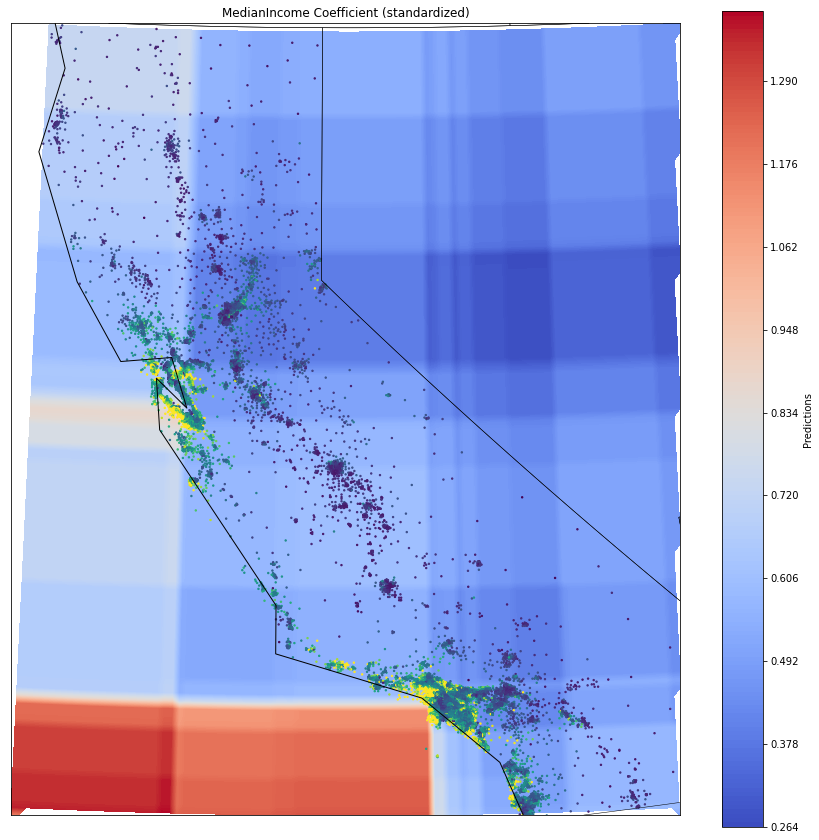

In [14]:
# Define the range of latitude and longitude
lat_range = np.linspace(np.min(X_train_coeff[:, 0]), np.max(X_train_coeff[:, 0]), 100)
lon_range = np.linspace(np.min(X_train_coeff[:, 1]), np.max(X_train_coeff[:, 1]), 100)

# Create the meshgrid
lat_mesh, lon_mesh = np.meshgrid(lat_range, lon_range)

# Flatten the meshgrid
lat_lon_mesh = np.concatenate([lat_mesh.reshape(-1, 1), lon_mesh.reshape(-1, 1)], 1)  

# Predict using the model
predictions = model._predict_coeffs(lat_lon_mesh)[:,1]

# Create a basemap
m = Basemap(llcrnrlon=np.min(X_train_coeff[:, 1]), llcrnrlat=np.min(X_train_coeff[:, 0]),
            urcrnrlon=np.max(X_train_coeff[:, 1]), urcrnrlat=np.max(X_train_coeff[:, 0]),
            projection='lcc', lat_0=np.mean(X_train_coeff[:, 0]), lon_0=np.mean(X_train_coeff[:, 1]))

# Create a contour plot
plt.figure(figsize=(15, 15))
m.contourf(lon_mesh, lat_mesh, predictions.reshape(lat_mesh.shape), cmap='coolwarm',latlon=True, levels=200)
plt.colorbar(label='Predictions')
m.scatter(X[:, -1], X[:, -2], latlon=True, c=y, s=2)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

plt.title('MedianIncome Coefficient (standardized)')
plt.show()


We see that the effect of `MedInc` is relatively stable throughout the many areas. In some coastal regions, particularly around Los Angeles and southern San Franscico/Palo Alto, the effect of Median Income is slightly higher. Compare this to the estimated, varying coefficient according to the Varying Coefficient Neural Network:

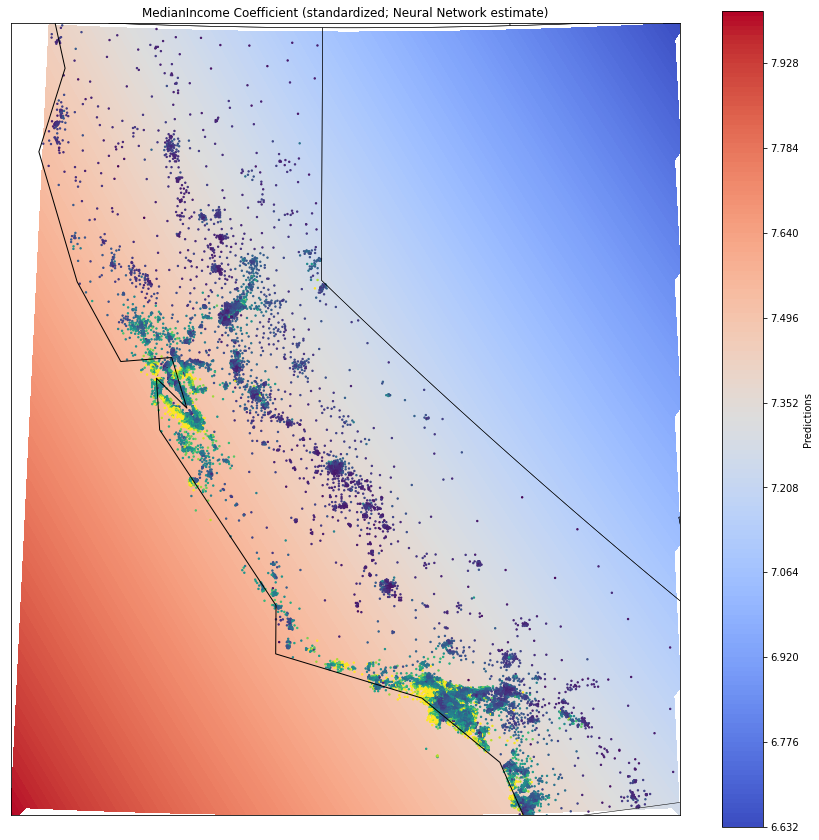

In [15]:
# Predict using the model
predictions = model_net.predict_coefficients(torch.tensor(lat_lon_mesh).float())[:,1].detach().numpy()

# Create a basemap
m = Basemap(llcrnrlon=np.min(X_train_coeff[:, 1]), llcrnrlat=np.min(X_train_coeff[:, 0]),
            urcrnrlon=np.max(X_train_coeff[:, 1]), urcrnrlat=np.max(X_train_coeff[:, 0]),
            projection='lcc', lat_0=np.mean(X_train_coeff[:, 0]), lon_0=np.mean(X_train_coeff[:, 1]))

# Create a contour plot
plt.figure(figsize=(15, 15))
m.contourf(lon_mesh, lat_mesh, predictions.reshape(lat_mesh.shape), cmap='coolwarm',latlon=True, levels=200)
plt.colorbar(label='Predictions')
m.scatter(X[:, -1], X[:, -2], latlon=True, c=y, s=2)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

plt.title('MedianIncome Coefficient (standardized; Neural Network estimate)')
plt.show()


With the Varying Coefficient Neural Network, the coefficient variation is much different from before. Instead of rectangular areas, the coefficients are now varying much more smoothly. This is obviously due to Neural Networks only being able to model smooth functions. Boosted Trees on the the other hand can also account for non-smooth functions that change rapidly within a small area. With regards to geospatial data, this can obviously be limiting - here, for example, if neighborhood conditions change rather rapdidly. 

Nevertheless, the model also accounts for coastal homes' prices being more influenced by Median Income. 

### Varying Coefficient Boosting for Bike Sharing Demand
Next up, we take a look at the [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand) dataset from Kaggle. The dataset contains hourly bike rental data from Washington D.C. Month, weekday and hour are obviously key features here. Thus, 

In [16]:

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

X = df.iloc[:,2:-1]
X["time"] = np.arange(len(X)) #add time axis for linear trend
y = df.iloc[:,-1]

X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)
X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)

X.drop(["month", "hour", "weekday"], axis=1, inplace=True)


# Create dummy variables for the specified columns
dummy_cols = ["holiday", "workingday", "weather"]
dummy_df = pd.get_dummies(X[dummy_cols], drop_first=True)

# Concatenate the dummy variables with the remaining columns
X = pd.concat([X.drop(dummy_cols, axis=1), dummy_df], axis=1)

X_train = X.iloc[:-1000]
X_test = X.iloc[-1000:]

y_train = np.log(y.iloc[:-1000]+1)
y_test = np.log(y.iloc[-1000:]+1)

data_features = ["weather_heavy_rain", "weather_misty", "weather_rain", "temp", "feel_temp", "humidity", "windspeed", "time", "holiday_False", "workingday_False"]

X_train_reg = np.float32(X_train[data_features])
X_train_coeff = np.float32(X_train.drop(data_features, axis=1))

X_test_reg = np.float32(X_test[data_features])
X_test_coeff = np.float32(X_test.drop(data_features, axis=1))

X_reg_mean = np.mean(X_train_reg, 0)
X_reg_std = np.std(X_train_reg, 0)

X_train_reg = (X_train_reg - X_reg_mean) / X_reg_std
X_test_reg = (X_test_reg - X_reg_mean) / X_reg_std

X_full_mean = np.mean(X_train, 0)
X_full_std = np.std(X_train, 0)

X_train_scaled = (X_train - X_full_mean) / X_full_std
X_test_scaled = (X_test - X_full_mean) / X_full_std

y_mean = np.mean(y_train)
y_std = np.std(y_train)

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std



In [17]:
np.random.seed(123)

model = VaryingCoefficientGradientBoosting(n_estimators=100, max_depth=2, learning_rate = 0.1)
model.fit(X_train_reg, X_train_coeff, y_train)

predictions_varcoeff = model.predict(X_test_reg, X_test_coeff)

rmse_varcoeff = np.sqrt(np.mean((predictions_varcoeff - y_test)**2))


gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=2, learning_rate = 0.1)
gb_model.fit(X_train_scaled, y_train)

predictions_gb = gb_model.predict(X_test_scaled)

rmse_gb = np.sqrt(np.mean((predictions_gb - y_test)**2))

In [18]:
np.random.seed(123)
torch.manual_seed(123)

model_net = VaryingCoefficientNeuralNetwork(input_dim=X_train_reg.shape[1], varying_input_dim=X_train_coeff.shape[1], hidden_dim=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_net.parameters(), lr=0.001)

model_net = VaryingCoefficientNeuralNetwork(input_dim=X_train_reg.shape[1]+1, varying_input_dim=X_train_coeff.shape[1], hidden_dim=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_net.parameters(), lr=0.001)

X_train_reg_tensor = torch.tensor(X_train_reg).float()
X_train_reg_tensor = torch.cat([torch.ones(X_train_reg_tensor.shape[0], 1), X_train_reg_tensor], 1)

X_test_reg_tensor = torch.tensor(X_test_reg).float()
X_test_reg_tensor = torch.cat([torch.ones(X_test_reg_tensor.shape[0], 1), X_test_reg_tensor], 1)

X_train_coeff_tensor = torch.tensor(X_train_coeff).float()
X_test_coeff_tensor = torch.tensor(X_test_coeff).float()

y_train_tensor = torch.tensor(y_train).float()

num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_net(X_train_reg_tensor, X_train_coeff_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

predictions = model_net(X_test_reg_tensor, X_test_coeff_tensor)

rmse_var_coeff_net = np.sqrt(np.mean((predictions.detach().numpy() - y_test)**2))

print(f"RMSE for Varying Coefficient Boosting: {rmse_varcoeff}")
print(f"RMSE for Gradient Boosting: {rmse_gb}")
print(f"RMSE for varying coefficient Neural Network: {rmse_var_coeff_net}")

RMSE for Varying Coefficient Boosting: 0.4491864065123828
RMSE for Gradient Boosting: 0.4917861604236747
RMSE for varying coefficient Neural Network: 0.4621447551672892


This time, the Varying Coefficient Boosting model even outperforms the standard Gradient Boosting model. Let us now compare how the Varying Coefficient Boosting model and the Varying Coefficient Neural Network model estimate the coefficient for the `temp` feature:

In [24]:
result_dict = {}

index = []
datalist = []

for hour in range(24):
    for month in range(12):
        for weekday in range(7):
            datalist.append([
                np.sin(2 * np.pi * hour / 24),
                np.cos(2 * np.pi * hour / 24),
                np.sin(2 * np.pi * month / 12),
                np.cos(2 * np.pi * month / 12),
                np.sin(2 * np.pi * weekday / 7),
                np.cos(2 * np.pi * weekday / 7),                
            ])

            index.append(f"{hour+1},{month+1},{weekday+1}")


predictions_vcb = model._predict_coeffs(np.array(datalist))
predictions_vcnn = model_net.predict_coefficients(torch.tensor(np.array(datalist)).float()).detach().numpy()

for i in range(len(predictions)):
    result_dict[index[i]] = {"vcb": f"{predictions_vcb[i,0]:.4f} + ... + {predictions_vcb[i,4]:.4f} * temp + ...",
                             "vcnn": f"{predictions_vcnn[i,0]:.4f} + ... + {predictions_vcnn[i,4]:.4f} * temp + ..."}




result_dict_json = json.dumps(result_dict)

html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Model Selector</title>
</head>
<body>
    <div style="text-align:center;">
    <label for="hour">Hour:</label>
    <input type="range" id="hour" name="hour" min="1" max="24" value="12" oninput="updateModel()">
    <span id="hourValue">12</span><br>

    <label for="month">Month:</label>
    <input type="range" id="month" name="month" min="1" max="12" value="8" oninput="updateModel()">
    <span id="monthValue">6</span><br>

    <label for="weekday">Weekday:</label>
    <input type="range" id="weekday" name="weekday" min="1" max="7" value="3" oninput="updateModel()">
    <span id="weekdayValue">3</span><br>

    <p>Varying Coefficient Boosting: <span id="vcbOutput"></span></p>
    <p>Varying Coefficient Neural Network: <span id="vcnnOutput"></span></p>
    </div>

    <script>
        var modelData = {result_dict_json};

        function updateModel() {{
            var hour = document.getElementById('hour').value;
            var month = document.getElementById('month').value;
            var weekday = document.getElementById('weekday').value;

            document.getElementById('hourValue').textContent = hour;
            document.getElementById('monthValue').textContent = month;
            document.getElementById('weekdayValue').textContent = weekday;

            var vcbModelString = modelData[hour + ',' + month + ',' + weekday]['vcb'];
            document.getElementById('vcbOutput').textContent = vcbModelString || 'No model available';
            var vcnnModelString = modelData[hour + ',' + month + ',' + weekday]['vcnn'];
            document.getElementById('vcnnOutput').textContent = vcnnModelString || 'No model available';

        }}

        // Initial update
        updateModel();
    </script>
</body>
</html>
"""

with open('interactive_model_selector.html', 'w') as f:
    f.write(html_template)

We find that the Varying Coefficient Network predict a negative `temp` coefficient at `hour=12, month=8, weekday=3`. On the contrary, the Varying Coefficient Boosting model appears to mostly predict a positive coefficient. This might be a good occassion to ask a domain expert for their opinion. Then, we could fine-tune the varying coefficients by, for example, requiring the coefficient to be either all-negative or all-positive.



## References

[1] Hastie, Trevor; Tishbirani, Robert. Varying-coefficient models. Journal of the Royal Statistical Society Series B: Statistical Methodology, 1993

[2] Yue, Mu; LI, Jialiang; Cheng, Ming-Yen. Two-step sparse boosting for high-dimensional longitudinal data with varying coefficients. Computational Statistics & Data Analysis, 2019

[3] Zhou, Yichen; Hooker, Giles. Decision tree boosted varying coefficient models. Data Mining and Knowledge Discovery, 2022